<a href="https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/ODSC_2022_%F0%9F%A4%97_Transformers_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using 🤗 Transformers and 🤗 Datasets filter customer feedback filtering**

Before diving into this notebook, we strongly recommend 
going through **all** the chapters of the official [🤗 Hugging Face course](https://huggingface.co/course/chapter1/1). This will make it much easier for 
you to follow this notebook and transfer the knowledge to **your** tasks.

In this notebook, we will simulate a real-world use 
case and try to solve it using tools of the Hugging Face ecosystem.

We strongly recommend using this notebook as a template/example to 
solve **your** real-world use case. Before the official workshop at the OSCD workshop starts, it will be very advantageous to have adapted the google colab for your use case so that the Hugging Face team can help you solve your specific questions.

# **Defining Task, Dataset & Model**

Before jumping into the actual coding part, it's important to have a clear definition of the use case that you would like to automate or partly automate.
A clear definition of the use case helps in identifying the most suitable task, dataset to use, and model to apply for your use case.

## **Define your NLP task**

Alright, let's dive into a hypothetical problem we wish to save using models of natural language processing. Let's assume, we are selling a product and our customer support team receives thousands of messages including feedback, complaints, and questions which ideally should all be answered. 

Quickly, it becomes obvious though that customer support is by no means able to reply to every message. Thus, we decide to only reply 
to the most unsatisfied custmoers and set the goal of replying to 100% of very unsatisfied messages.

Assuming that a) messages of very unsatisfied customers represent only a fraction of all messages and b) that we can filter out unsatisfied messages in an automated way, customer support should be able to reach this goal.

To filter out unsatisfied messages in an automated way, we plan on applying natural language processing technologies. 


The first step is now to map our use case - *filtering out unsatisfied messages* - to a natural language processing task.

To do so, it is recommended to go over all available tasks on the Hugging Face Hub [here](https://huggingface.co/tasks). If you are not sure which task applies to your use case, you should click on all of the different tasks to better understand them, *e.g.* 

Automatically replying  The task of finding messages of the most unsatisfied customers can be labeled as a text classification task: Classify a message into one of *very unsatisfied*, *unsatisfied*, *neutral*, *satisfied*, or *very satisfied*.



## **Find suitable datasets**

Having decided on the task, next we should find the data the model will be trained on. This is usually more important for the downstream performance of your use case than picking the right model architecture.
Keep in mind that a model is **only as good as the data it has been trained on**. Thus, we should be very careful when curating and/or selecting the dataset.

Since we consider the hypothetical use case of *filtering out unsatisfied messages*, let's look into what datasets are available to us.

For your real-world use case, it is **very likely** that you have internal data that best represents the actual data your NLP system is supposed to handle. Therefore, you should use such internal data to train your NLP system.
It can nevertheless be helpful to also include publicly available to improve the generalizability of your model.

Let's take a look at all available Datasets on the [Hugging Face Hub](https://huggingface.co/datasets). On the left side, you can filter the datasets according to *Task Categories* as well as *Tasks* which are more specific. Our use case corresponds to *Text Classification* -> *Sentiment Analysis* so let's select [these filters](https://huggingface.co/datasets?task_categories=task_categories:text-classification&task_ids=task_ids:sentiment-classification&sort=downloads). We are left with *ca.* 80 datasets at the time of writing this notebook. Two aspects should be evaluated when picking a dataset:

- **Quality**: Is the dataset of high quality? More specifically: Does the data correspond to the data you expect to deal with in your use case? Is the data diverse, unbiased, ...?
- **Size**: How big is the dataset? Usually one can safely say the bigger the dataset, the better.

It's quite difficult to efficiently evaluate whether a dataset is of high quality and it's even more difficult to know whether and how the dataset is biased.
 An efficient and reasonable heuristic for high quality is to look at the download statistics. The more downloads, the more usage, the higher chance that the dataset is of high quality. The size is easy to evaluate as it can usually be quickly read upon. Let's take a look at the most downloaded datasets:

- [Glue](https://huggingface.co/datasets/glue)
- [Amazon polarity](https://huggingface.co/datasets/amazon_polarity)
- [Tweet eval](https://huggingface.co/datasets/tweet_eval)
- [Yelp review full](https://huggingface.co/datasets/yelp_review_full)
- [Amazon reviews multi](https://huggingface.co/datasets/amazon_reviews_multi)

Now we can inspect those datasets in more detail by reading through the dataset card which ideally should give all relevant and important information. In addition, the [dataset viewer](https://huggingface.co/datasets/glue/viewer/cola/test) is an incredibly powerful tool to inspect whether the data suits your use case.

Let's quickly go over the dataset cards of the models above: 
- *GLUE* is a collection of small datasets that mostly serves as a means to compare new model architectures for researchers. The datasets are too small and don't correspond enough to our use case.
- *Amazon polarity* is huge and a well-suited dataset for customer feedback since the data deals with customer reviews. However, it only has binary labels (positive/negative) whereas we are looking for more granularity in the sentiment classification. 
- *Tweet eval* uses different emojis as labels which cannot that easily be mapped to a scale going from unsatisfied to satisfied.
- *Amazon reviews multi* seems to be the most suited dataset here. We have sentiment labels ranging from 1-5 corresponding to 1-5 stars on Amazon. These labels can very well be mapped to *very unsatisfied, unsatisfied, neutral, satisfied, very satisfied*. Having inspected some examples on [the dataset viewer](https://huggingface.co/datasets/amazon_reviews_multi/viewer/en/train) we can see that the reviews look very similar to how customer feedback reviews would look, so this seems like a very good dataset. In addition, each review has a `product_category` label so we could even go as far as to only use reviews of a product category that corresponds to the one we are working in. The dataset is multi-lingual, but we are just interested in the English version for now.
- *Yelp review full* looks like a very suitable dataset. It's large and contains product reviews and sentiment labels from 1 to 5. Sadly, the dataset viewer is not working here at the moment and the dataset card is also relatively sparse requiring some more time to inspect the dataset. At this point, we should read the paper, but given the time-constraint of this blog post, we'll choose to go for *Amazon reviews multi*.

As a conclusion, let's focus on the [*Amazon reviews multi*](https://huggingface.co/datasets/amazon_reviews_multi) dataset considering all training examples.

As a final note, we recommend making use of Hub's dataset functionality even when working with private datasets. The Hugging Face Hub, Transformers, and Datasets are flawlessly integrated, which makes it trivial to use them in combination when training models.

In addition, the Hugging Face Hub offers:

- [A dataset viewer for every dataset](https://huggingface.co/datasets/amazon_reviews_multi)
- [Easy demoing of every model using widgets](https://huggingface.co/docs/hub/main#whats-a-widget)
- [Private and Public models](https://huggingface.co/docs/hub/adding-a-model#creating-a-repository)
- [Git version control for repositories](https://huggingface.co/docs/hub/main#whats-a-repository)
- [Highest security mechanisms](https://huggingface.co/docs/hub/security)

## **Find a suitable model**

Having decided on the task and the dataset that best describes our use case, we can now look into choosing a model to be used.

Most likely, you will have to fine-tune a pretrained model for your use case, but it is worth checking whether they are already fine-tuned models on the Hub that perform well. In this case, you might reach a higher performance by just continuing to fine-tune such a model on your dataset.

Let's take a look at all models that have been fine-tuned on Amazon Reviews Multi, you can find the list of models on the bottom right corner - clicking on *Browse models trained on this dataset* you can see [a list of all models fine-tuned on the dataset that are publicly available](https://huggingface.co/models?dataset=dataset:amazon_reviews_multi). Note that we are only interested in the English version of the dataset because our customer feedback will only be in English. It looks like most of the most downloaded models are trained on the multi-lingual version of the dataset and those that don't seem to be multi-lingual have very little information or poor performance. At this point, 
it might be more sensible to fine-tune a purely pretrained model instead of using one of the already fine-tuned ones shown in the link above.

Alright, the next step now is to find a suitable pretrained model to be used for fine-tuning. This is actually more difficult than it seems given the large amount of pretrained and fine-tuned models that are the [Hugging Face Hub](https://huggingface.co/models) . The best option is usually to simply try out a variety of different models to see which one performs best. 
We still haven't found the perfect way of comparing different model checkpoints to each other at Hugging Face, but we provide some resources that are worth looking into:

- The [model summary](https://huggingface.co/docs/transformers/model_summary) gives a short overview of different model architectures.
- A task-specific search on the Hugging Face Hub, *e.g.* [a search on text-classification models](https://huggingface.co/models), shows you the most downloaded checkpoints which is also an indication of how well those checkpoints perform.

Both of the above resources are currently however a bit suboptimal. The model summary is not always kept up to date. The speed at which new model architectures are released and old model architectures become outdated makes it extremely difficult to have an up-to-date summary of all model architectures.
Similarly, it doesn't necessarily mean that the most downloaded model checkpoint is the best one. E.g. [`bert-base-cased`](https://huggingface.co/bert-base-uncased) is amongst the most downloaded model checkpoints but is not the best performing checkpoint anymore.  

The best is often to try out a variety of different model architectures, stay up to date with new model architectures by following experts in the field and checking well-known leaderboards.

For text-classification, the important benchmarks to look at are [GLUE](https://gluebenchmark.com/leaderboard) and [SuperGLUE](https://super.gluebenchmark.com/leaderboard). Both benchmarks evaluate pretrained models on a variety of text-classification tasks, such as grammatical correctness, natural language inference, Yes/No question answering, etc..., which are quite similar to our target task of sentiment analysis. Thus, it is reasonable to choose one of the leading models of these benchmarks for our task.

At the time of writing this notebook, the best performing models are very large models containing more than 10 billion parameters most of which are not open-sourced, *e.g.* *ST-MoE-32B*, *Turing NLR v5*, or
*ERNIE 3.0*. One of the top-ranking models that is easily accessible is [DeBERTa](https://huggingface.co/docs/transformers/model_doc/deberta). Because  Let's try out DeBERTa's newest base version - *i.e.* [`microsoft/deberta-v3-base`](https://huggingface.co/microsoft/deberta-v3-base).

# **Training / Fine-tuning a model with 🤗 Transformers and 🤗 Datasets**

In this section, we will jump into the technical details of how to 
fine-tune a model end-to-end to be able to automatically filter out very unsatisfied customer feedback messages.

Cool, let's start by installing all necessary pip packages and by setting up our code environment, then look into preprocessing the dataset and finally start training the model.

The following notebook can be run online in a google colab pro with the GPU runtime environment enabled.

## **Install all necessary packages**

To begin with, let's install [`git-lfs`](https://git-lfs.github.com/) so that we can automatically upload our trained checkpoints to the Hub during training.

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (18.5 MB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Also, we install the 🤗 Transformers and 🤗 Datasets libraries to run this notebook. Since we will be using [DeBERTa](https://huggingface.co/docs/transformers/model_doc/deberta-v2#debertav2) in this notebook, we also need to install the [`sentencepiece`](https://github.com/google/sentencepiece) library for its tokenizer.

In [ ]:
%%capture
!pip install datasets transformers[sentencepiece]

Next, let's login into our [Hugging Face account](https://huggingface.co/join) so that models are uploaded correctly under your name tag.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## **Preprocess the dataset**

Before we can start training the model, we should bring the dataset in a format 
that is understandable by the model.

Thankfully, the 🤗 Datasets library makes this extremely easy as you will see in the following cells.

The `load_dataset` function loads the dataset, nicely arranges it into predefined attributes, such as `review_body` and `stars`, and finally saves the newly arranged data using the [arrow format](https://arrow.apache.org/#:~:text=Format,data%20access%20without%20serialization%20overhead.) on disk. 
The arrow format allows for fast and memory-efficient data reading and writing.

Let's load and prepare the English version of the `amazon_reviews_multi` dataset.

In [ ]:
from datasets import load_dataset

amazon_review = load_dataset("amazon_reviews_multi", "en")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Great, that was fast 🔥. Let's take a look at the structure of the dataset.

In [ ]:
amazon_review

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

We have 200,000 training examples as well as 5000 validation and test examples. This sounds reasonable for training! We're only really interested in the input being the `"review_body"` column and the target being the `"starts"` column.

Let's check out a random example.

In [ ]:
random_id = 34

print("Stars:", amazon_review["train"][random_id]["stars"])
print("Review:", amazon_review["train"][random_id]["review_body"])

Stars: 1
Review: This product caused severe burning of my skin. I have used other brands with no problems


The dataset is in a human-readable format, but now we need to transform it into a "machine-readable" format. Let's define the model repository which includes all utils necessary to preprocess and fine-tune the checkpoint we decided on.

In [ ]:
model_repository = "microsoft/deberta-v3-base"

Next, we load the tokenizer of the model repository, which is a [DeBERTa's Tokenizer](https://huggingface.co/docs/transformers/model_doc/deberta-v2#transformers.DebertaV2Tokenizer).

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_repository)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


As mentioned before, we will use the `"review_body"` as the model's input and `"stars"` as the model's target. Next, we make use of the tokenizer to transform the input into a sequence of token ids that can be understood by the model. The tokenizer does exactly this and can also help you to limit your input data to a certain length to not run into a memory issue. Here, we limit 
the maximum length to 128 tokens which in the case of DeBERTa corresponds to roughly 100 words which in turn corresponds to *ca.* 5-7 sentences. Looking at the [dataset viewer](https://huggingface.co/datasets/amazon_reviews_multi/viewer/en/test) again, we can see that this covers pretty much all training examples. 
**Important**: This doesn't mean that our model cannot handle longer input sequences, it just means that we use a maximum length of 128 for training since it covers 99% of our training and we don't want to waste memory. Transformer models have shown to be very good at generalizing to longer sequences after training.

If you want to learn more about tokenization in general, please have a look at [the Tokenizers docs](https://huggingface.co/course/chapter6/1?fw=pt).

The labels are easy to transform as they already correspond to numbers in their raw form, *i.e.* the range from 1 to 5. Here we just shift the labels into the range 0 to 4 since indexes usually start at 0.

Great, let's pour our thoughts into some code. We will define a `preprocess_function` that we'll apply to each data sample. 

In [ ]:
def preprocess_function(example):
    output_dict = tokenizer(example["review_body"], max_length=128, truncation=True)
    output_dict["labels"] = [e - 1 for e in example["stars"]]
    return output_dict

To apply this function to all data samples in our dataset, we just use the [`map`](https://huggingface.co/docs/datasets/master/en/package_reference/main_classes#datasets.Dataset.map) method of the `amazon_review` object we created earlier. This will apply the function on all the elements of all the splits in `amazon_review`, so our training, validation, and testing data will be preprocessed in one single command. We run the mapping function in `batched=True` mode to speed up the process and also remove all columns since we don't need them anymore for training.

In [ ]:
tokenized_datasets = amazon_review.map(preprocess_function, batched=True, remove_columns=amazon_review["train"].column_names)

  0%|          | 0/200 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Let's take a look at the new structure.

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

We can see that the outer layer of the structure stayed the same but the naming of the columns has changed. 
Let's take a look at the same random example we looked at previously only that it's preprocessed now.

In [ ]:
print("Input IDS:", tokenized_datasets["train"][random_id]["input_ids"])
print("Labels:", tokenized_datasets["train"][random_id]["labels"])

Input IDS: [1, 329, 714, 2044, 3567, 5127, 265, 312, 1158, 260, 273, 286, 427, 340, 3006, 275, 363, 947, 2]
Labels: 0


Alright, the input text is transformed into a sequence of integers which can be transformed to word embeddings by the model, and the label index is simply shifted by -1.

## **Fine-tune the model**

Having preprocessed the dataset, next we can fine-tune the model. We will make use of the popular [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) which allows us to start training in just a couple of lines of code. The Trainer can be used for more or less all tasks in PyTorch and is extremely convenient by taking care of a lot of boilerplate code needed for training.

 Let's start by loading the model checkpoint using the convenient [`AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSequenceClassification). Since the checkpoint of the model repository is just a pretrained checkpoint we should define the size of the classification head by passing `num_lables=5` (since we have 5 sentiment classes).

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_repository, num_labels=5)

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Next, we load a data collator. A [data collator](https://huggingface.co/docs/transformers/main_classes/data_collator) is responsible for making sure each batch is correctly padded during training, which should happen dynamically since training samples are reshuffled before each epoch.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

During training, it is important to monitor the performance of the model on a held-out validation set. To do so, we should pass a to define a `compute_metrics` function to the `Trainer` which is then called at each validation step during training.

The simplest metric for the text classification task is *accuracy*, which simply states how much percent of the training samples were correctly classified. Using the *accuracy* metric might be problematic however if the validation or test data is very unbalanced. Let's verify quickly that this is not the case by counting the occurrences of each label.

In [ ]:
from collections import Counter

print("Validation:", Counter(tokenized_datasets["validation"]["labels"]))
print("Test:", Counter(tokenized_datasets["test"]["labels"]))

Validation: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000})
Test: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000})


The validation and test data sets are as balanced as they can be, so we can safely use accuracy here!

 Let's load the [accuracy metric](https://huggingface.co/metrics/accuracy) via the datasets library.

In [ ]:
from datasets import load_metric

accuracy = load_metric("accuracy")

Next, we define the `compute_metrics` which will be applied to the predicted outputs of the model which is of type [`EvalPrediction`](https://huggingface.co/docs/transformers/main/en/internal/trainer_utils#transformers.EvalPrediction) and therefore exposes the model's predictions and the gold labels.
We compute the predicted label class by taking the `argmax` of the model's prediction before passing it alongside the gold labels to the accuracy metric.

In [ ]:
import numpy as np

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_classes = np.argmax(pred_logits, axis=-1)
    labels = np.asarray(pred.label_ids)

    acc = accuracy.compute(predictions=pred_classes, references=labels)

    return {"accuracy": acc["accuracy"]}

Great, now all components required for training are ready and all that's left to do is to define the hyper-parameters of the `Trainer`. We need to make sure that the model checkpoints are uploaded to the Hugging Face Hub during training. By setting `push_to_hub=True`, this is done automatically at every `save_steps` via the convenient [`push_to_hub`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

Besides, we define some standard hyper-parameters such as learning rate, warm-up steps and training epochs. We will log the loss every 500 steps and run evaluation every 5000 steps.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="deberta_amazon_reviews_v1",
    num_train_epochs=2, 
    learning_rate=2e-5,
    warmup_steps=200,
    logging_steps=500,
    save_steps=5000,
    eval_steps=5000,
    push_to_hub=True,
    evaluation_strategy="steps",
)

Putting it all together, we can finally instantiate the Trainer by passing all required components. We'll use the `"validation"` split as the held-out dataset during training.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    args=training_args,
    compute_metrics=compute_metrics,
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"]
)

The Trainer is ready to go 🚀 You can start training by calling `trainer.train()`.

In [ ]:
train_metrics = trainer.train().metrics
trainer.save_metrics("train", train_metrics)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 200000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50000


Step,Training Loss,Validation Loss,Accuracy
5000,0.931200,0.979602,0.585600


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to deberta_amazon_reviews_v1/checkpoint-5000
Configuration saved in deberta_amazon_reviews_v1/checkpoint-5000/config.json
Model weights saved in deberta_amazon_reviews_v1/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in deberta_amazon_reviews_v1/checkpoint-5000/tokenizer_config.json
Special tokens file saved in deberta_amazon_reviews_v1/checkpoint-5000/special_tokens_map.json
added tokens file saved in deberta_amazon_reviews_v1/checkpoint-5000/added_tokens.json
tokenizer config file saved in deberta_amazon_reviews_v1/tokenizer_config.json
Special tokens file saved in deberta_amazon_reviews_v1/special_tokens_map.json
added tokens file saved in deberta_amazon_reviews_v1/added_tokens.json


Step,Training Loss,Validation Loss,Accuracy
5000,0.931200,0.979602,0.585600
10000,0.931600,0.933607,0.597400
15000,0.907600,0.917062,0.602600
20000,0.902400,0.919414,0.604600
25000,0.879400,0.910928,0.608400
30000,0.806700,0.933923,0.609200
35000,0.826800,0.907260,0.616200
40000,0.820500,0.904160,0.615800
45000,0.795000,0.918947,0.616800
50000,0.783600,0.907572,0.618400


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to deberta_amazon_reviews_v1/checkpoint-10000
Configuration saved in deberta_amazon_reviews_v1/checkpoint-10000/config.json
Model weights saved in deberta_amazon_reviews_v1/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in deberta_amazon_reviews_v1/checkpoint-10000/tokenizer_config.json
Special tokens file saved in deberta_amazon_reviews_v1/checkpoint-10000/special_tokens_map.json
added tokens file saved in deberta_amazon_reviews_v1/checkpoint-10000/added_tokens.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to deberta_amazon_reviews_v1/checkpoint-15000
Configuration saved in deberta_amazon_reviews_v1/checkpoint-15000/config.json
Model weights saved in deberta_amazon_reviews_v1/checkpoint-15000/pytorch_model.bin
tokenizer config file saved in deberta_amazon_reviews_v1/checkpoint-15000/tokenizer_config.json
Special tokens file 

Cool, we see that the model seems to learn something! Training loss and validation loss is going down and the accuracy also ends up being well over random chance (20%). Interestingly, we see accuracy of around **58.6 %** already after 5000 steps which doesn't improve that much anymore afterward. Choosing a bigger model or training for longer would have probably given better results here, but that's good enough for our hypothetical use case!

Alright, finally let's upload the model checkpoint to the Hub.

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to deberta_amazon_reviews_v1
Configuration saved in deberta_amazon_reviews_v1/config.json
Model weights saved in deberta_amazon_reviews_v1/pytorch_model.bin
tokenizer config file saved in deberta_amazon_reviews_v1/tokenizer_config.json
Special tokens file saved in deberta_amazon_reviews_v1/special_tokens_map.json
added tokens file saved in deberta_amazon_reviews_v1/added_tokens.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/704M [00:00<?, ?B/s]

Upload file runs/Mar25_13-12-56_e6867fac5e92/events.out.tfevents.1648214287.e6867fac5e92.74.0:  15%|#4        …

remote: tput: No value for $TERM and no -T specified        
remote: tput: No value for $TERM and no -T specified        
remote: tput: No value for $TERM and no -T specified        
remote: tput: No value for $TERM and no -T specified        
To https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1
   028081a..7f3172e  main -> main

remote: tput: No value for $TERM and no -T specified        
remote: tput: No value for $TERM and no -T specified        
remote: tput: No value for $TERM and no -T specified        
remote: tput: No value for $TERM and no -T specified        
To https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1
   7f3172e..599b891  main -> main



'https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1/commit/7f3172e3457e9f20305db66972ae64b21d70d9b1'

## **Evaluate / Analyse the model**

Now that we have fine-tuned the model we need to be very careful about analyzing its performance. It's usually not enough to just look at basic metrics defining the quality of a model purely on a metric, such as *accuracy*.
The better approach is to find a metric that best describes the actual use case of the model.

Let's dive into evaluating the model 🤿.

The model has been uploaded to the Hub under [`deberta_v3_amazon_reviews`](https://huggingface.co/patrickvonplaten/deberta_v3_amazon_reviews) after training, so in a first step, let's download it from there again. If this notebook is run all at once the following cell will simply load the model from the cache.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("patrickvonplaten/deberta_v3_amazon_reviews")

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/704M [00:00<?, ?B/s]

The Trainer is not only an excellent class to train a model, but also to evaluate a model on a dataset. Let's instantiate the trainer with the same instances and functions as before, but this time there is no need to pass a training dataset.

In [ ]:
trainer = Trainer(
    args=training_args,
    compute_metrics=compute_metrics,
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Cloning https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1 into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.58k/704M [00:00<?, ?B/s]

Download file runs/Mar25_10-17-17_39304753b90c/1648203455.8195853/events.out.tfevents.1648203455.39304753b90c.…

Download file runs/Mar25_13-12-56_e6867fac5e92/1648214287.7501392/events.out.tfevents.1648214287.e6867fac5e92.…

Download file runs/Mar25_10-17-17_39304753b90c/events.out.tfevents.1648203455.39304753b90c.74.0:  89%|########…

Clean file runs/Mar25_10-17-17_39304753b90c/1648203455.8195853/events.out.tfevents.1648203455.39304753b90c.74.…

Clean file runs/Mar25_10-17-17_39304753b90c/events.out.tfevents.1648203455.39304753b90c.74.0:  26%|##5       |…

Download file runs/Mar25_13-12-56_e6867fac5e92/events.out.tfevents.1648214287.e6867fac5e92.74.0:  15%|#5      …

Clean file runs/Mar25_13-12-56_e6867fac5e92/1648214287.7501392/events.out.tfevents.1648214287.e6867fac5e92.74.…

Download file spm.model:   0%|          | 3.48k/2.35M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.92k/2.92k [00:00<?, ?B/s]

Clean file training_args.bin:  34%|###4      | 1.00k/2.92k [00:00<?, ?B/s]

Clean file runs/Mar25_13-12-56_e6867fac5e92/events.out.tfevents.1648214287.e6867fac5e92.74.0:   4%|4         |…

Clean file spm.model:   0%|          | 1.00k/2.35M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/704M [00:00<?, ?B/s]

We use the Trainer's [`predict`]( ) function to evaluate the model on the test dataset on the same metric 

In [ ]:
prediction_metrics = trainer.predict(tokenized_datasets["test"]).metrics
prediction_metrics

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


{'test_accuracy': 0.608,
 'test_loss': 0.9637690186500549,
 'test_runtime': 21.9574,
 'test_samples_per_second': 227.714,
 'test_steps_per_second': 28.464}

The results are very similar to performance on the validation dataset, which is usually a good sign as it shows that the model didn't overfit the test dataset.

However, 60% accuracy is far from being perfect on a 5-class classification problem, but do we need very high accuracy for all classes?

Since we are mostly concerned with very negative customer feedback, let's maybe just focus on how well the model performs on classifying reviews of the most unsatisfied customers. Also, we decide to help the model a bit - all feedback classified as either **very unsatisfied** or **unsatisfied** will be handled by us - to catch close to 99% of the **very unsatisfied** messages. At the same time, we also measure how many **unsatisfied** messages we can answer this way and how much unnecessary work we do by answering messages of neutral, satisfied, and very satisfied customers.

Great, let's write a new `compute_metrics` function.

In [ ]:
import numpy as np

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_classes = np.argmax(pred_logits, axis=-1)
    labels = np.asarray(pred.label_ids)

    # First let's compute % of very unsatisfied messages we can catch
    very_unsatisfied_label_idx = (labels == 0)
    very_unsatisfied_pred = pred_classes[very_unsatisfied_label_idx]

    # now both 0 and 1 labels are 0 labels the rest is > 0
    very_unsatisfied_pred = very_unsatisfied_pred * (very_unsatisfied_pred - 1)
    
    # Let's count how many labels are 0 -> that's the "very unsatisfied"-accuracy
    true_positives = sum(very_unsatisfied_pred == 0) / len(very_unsatisfied_pred)

    # Second let's compute how many satisfied messages we unnecessarily reply to
    satisfied_label_idx = (labels > 1)
    satisfied_pred = pred_classes[satisfied_label_idx]

    # how many predictions are labeled as unsatisfied over all satisfied messages?
    false_positives = sum(satisfied_pred <= 1) / len(satisfied_pred)

    return {"%_unsatisfied_replied": round(true_positives, 2), "%_satisfied_incorrectly_labels": round(false_positives, 2)}

We again instantiate the Trainer to easily run the evaluation.

In [ ]:
trainer = Trainer(
    args=training_args,
    compute_metrics=compute_metrics,
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/content/deberta_amazon_reviews_v1 is already a clone of https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1. Make sure you pull the latest changes with `repo.git_pull()`.


And let's run the evaluation again with our new metric computation which is better suited for our use case.

In [ ]:
prediction_metrics = trainer.predict(tokenized_datasets["test"]).metrics
prediction_metrics

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


{'test_%_satisfied_incorrectly_labels': 0.11733333333333333,
 'test_%_unsatisfied_replied': 0.949,
 'test_loss': 0.9637690186500549,
 'test_runtime': 22.8964,
 'test_samples_per_second': 218.375,
 'test_steps_per_second': 27.297}

Cool! This already paints a pretty nice picture. We catch around 95% of **very unsatisfied** customers automatically at a cost of wasting our efforts on 10% of satisfied messages.

Let's do some quick math. We receive daily around 10,000 messages for which we expect ca. 500 to be very negative. Instead of having to answer to all 10,000 messages, using this automatic filtering, we would only need to look into 500 + 0.12 * 10,000 = 1700 messages and only reply to 475 messages while incorrectly missing 5% of the messages. Pretty nice - a 83% reduction in human effort at missing only 5% of very unsatisfied customers!

Obviously, the numbers don't represent the gained value of an actual use case, but we could come close to it with enough high-quality training data of your real-world example!

Let's save the results

In [ ]:
trainer.save_metrics("prediction", prediction_metrics)

and again upload everything on the Hub.

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to deberta_amazon_reviews_v1
Configuration saved in deberta_amazon_reviews_v1/config.json
Model weights saved in deberta_amazon_reviews_v1/pytorch_model.bin
tokenizer config file saved in deberta_amazon_reviews_v1/tokenizer_config.json
Special tokens file saved in deberta_amazon_reviews_v1/special_tokens_map.json
added tokens file saved in deberta_amazon_reviews_v1/added_tokens.json
To https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1
   599b891..ad77e6d  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1
   ad77e6d..13e5ddd  main -> main



'https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1/commit/ad77e6da4fdbd07678a91ac57af6652ecb3d3b83'

The data is now saved [here](https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1/blob/main/prediction_results.json).

That's it for today 😎. As a final step, it would also make a lot of sense to try the model out on actual real-world data. This can be done directly on the inference widget on [the model card](https://huggingface.co/patrickvonplaten/deberta_amazon_reviews_v1):

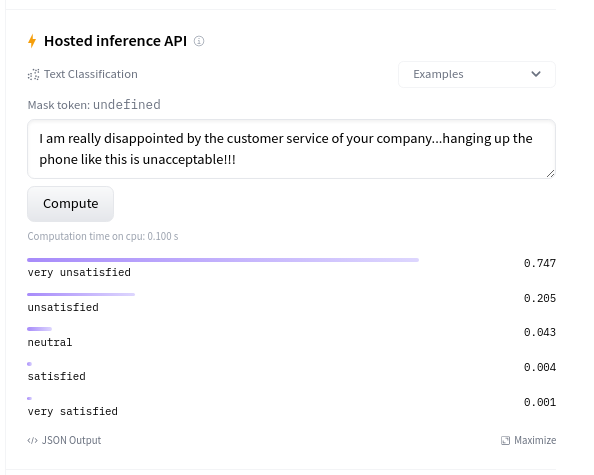

It does seem to generalize quite well to real-world data 🔥

## Optimization

As soon as you think the model's performance is good enough for production it's all about making the model as memory efficient and fast as possible.

There are some obvious solutions to this like choosing the best suited accelerated hardware, *e.g.* better GPUs, making sure no gradients are computed during the forward pass, or lowering the precision, *e.g.* to float16. 

More advanced optimization methods include using open-source accelerator libraries such as [ONNX Runtime](https://onnxruntime.ai/index.html), [quantization](https://pytorch.org/docs/stable/quantization.html), and inference servers like [Triton](https://developer.nvidia.com/nvidia-triton-inference-server).

At Hugging Face, we have been working a lot to facilitate the optimization of models, especially with our open-source [Optimum library](https://huggingface.co/hardware). Optimum makes it extremely simple to optimize most 🤗 Transformers models.

If you're looking for **highly optimized** solutions which don't require any technical knowledge, you might be interested in one of Hugging Face's paid inference services:

- [Inference API](https://huggingface.co/inference-api)
- [Infinity](https://huggingface.co/infinity)